In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np

In [4]:
import pymc4 as pm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Eager

In [125]:
@pm.model(auto_name=True)
def t_test():
    mu = pm.Normal(0, 1)
    sd = pm.HalfNormal(1)
    x1 = pm.Normal(0, 2 * sd)
    x2 = pm.Normal(0, 2 * sd)

model = t_test.configure()

model._forward_context.vars
func = model.make_log_prob_function()

In [6]:
mu = tf.ones((10,))
sd = tf.ones((10,))
y_0 = tf.ones((10,))
y_1 = tf.ones((10,))
%timeit logp = func(mu, sd, y_0, y_1)
func(mu, sd, y_0, y_1)

8.17 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<tf.Tensor: id=290153, shape=(), dtype=float32, numpy=-inf>

In [7]:
logp_func_defun = tf.function(func)

In [8]:
mu = tf.ones((10,))
sd = tf.ones((10,))
y_0 = tf.ones((10,))
y_1 = tf.ones((10,))

In [9]:
logp_func_defun(mu, sd, y_0, y_1) # warmup
%timeit logp = logp_func_defun(mu, sd, y_0, y_1)
logp_func_defun(mu, sd, y_0, y_1)

214 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<tf.Tensor: id=298547, shape=(), dtype=float32, numpy=-inf>

In [162]:
#%%timeit
with tf.GradientTape() as tape:
    tape.watch(mu)
    tape.watch(sd)
    tape.watch(y_0)
    tape.watch(y_1)
    logp = logp_func_defun(mu, sd, y_0, y_1)

tape.gradient(logp, [mu, sd, y_0, y_1])

[<tf.Tensor: id=29473712, shape=(10,), dtype=float32, numpy=array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>,
 <tf.Tensor: id=29473713, shape=(10,), dtype=float32, numpy=array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)>,
 <tf.Tensor: id=29473714, shape=(10,), dtype=float32, numpy=
 array([-0.03383382, -0.03383382, -0.03383382, -0.03383382, -0.03383382,
        -0.03383382, -0.03383382, -0.03383382, -0.03383382, -0.03383382],
       dtype=float32)>,
 <tf.Tensor: id=29473715, shape=(10,), dtype=float32, numpy=array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.], dtype=float32)>]

In [161]:
tape.gradient(logp, [mu, sd, y_0, y_1])

NameError: name 'tape' is not defined

In [131]:
def logp_and_grad(*args):
    logp = func(*args)
    return logp, tf.gradients(logp, args)

logp_grad_func_defun = tf.function(logp_and_grad)

array = tf.ones(4) * .05

@tf.function
def logp_array(array):
    mu = array[0]
    sd = array[1]
    y_0 = array[2]
    y_1 = array[3]
    logp = func(mu, sd, y_0, y_1)
    grad = tf.gradients(logp, array)
    return logp, grad

#logp_grad_func_defun(mu, sd, y_0, y_1) # warump 
#%timeit logp = logp_grad_func_defun(mu, sd, y_0, y_1)
logp_grad_func_defun(mu, sd, y_0, y_1)
logp_array(array)

(<tf.Tensor: id=28509715, shape=(), dtype=float32, numpy=-7.512924>,
 [<tf.Tensor: id=28509716, shape=(4,), dtype=float32, numpy=array([-0.05      , -9.554308  , -0.01131047, -0.01131047], dtype=float32)>])

In [155]:
def logp_wrapper(array):
    #print('input', array)
    logp, grad = logp_array(tf.convert_to_tensor(array))
    #print('logp', logp.numpy())
    #print('grad', grad[0].numpy())
    return logp.numpy(), grad[0].numpy()

In [128]:
from pymc4._hmc import HamiltonianMC
import arviz as az

In [156]:
hmc = HamiltonianMC(logp_dlogp_func=logp_wrapper, size=4, adapt_step_size=False)

In [75]:
curr, stat = hmc.step(curr)

In [158]:
hmc.step_size

2.7603081572936726e-05

In [157]:
curr = np.ones(4, dtype='float32') * .05
posterior_samples = []
stats = []
for i in range(50):
    print(i)
    curr, stat = hmc.step(curr)
    posterior_samples.append(curr)
    stats.append(stat)
    
trace = np.array(posterior_samples)

0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

In [118]:
trace = np.array(posterior_samples)

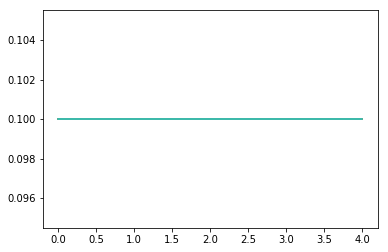

In [120]:
plt.plot(trace);

In [114]:
az.plot_trace(trace);

ValueError: Can only convert xarray dataset, dict, netcdf file, numpy array, pystan fit, pymc3 trace to InferenceData, not DataArray

In [17]:
from tensorflow.contrib.compiler import xla

In [20]:
# Doesn't work
array = tf.ones(40)

@tf.function
def logp_wrapper(array):
    mu = array[:10]
    sd = array[10:20]
    y_0 = array[20:30]
    y_1 = array[30:40]
    logp = func(mu, sd, y_0, y_1)
    grad = tf.gradients(logp, array)
    return logp, grad

#@tf.function
def logp_wrapper_xla(array):
    logp, grad = xla.compile(logp_wrapper, inputs=[array])
    return logp, grad

logp_wrapper_xla(array)

ValueError: When eager execution is enabled, use_resource cannot be set to false.

In [ ]:
%timeit logp_wrapper(array)

## Comparison to PyMC3

In [ ]:
import pymc3 as pm3

In [ ]:
with pm3.Model() as model:
    mu = pm3.Normal('mu', 0, 1, shape=10)
    sd = pm3.HalfNormal('sd', sd=1, transform=None, shape=10)
    pm3.Normal('y_0', 0, 2 * sd, shape=10)
    pm3.Normal('y_1', mu, 2 * sd, shape=10)

In [ ]:
func_pm3 = model.logp_dlogp_function()

In [ ]:
x0 = np.ones(func_pm3.size)

In [ ]:
func_pm3.set_extra_values({})
%timeit func_pm3(x0)